In [1]:
import pandas as pd
import numpy as np

In [167]:
import os
#TRAIN_ABLE_FALSE=True
#if TRAIN_ABLE_FALSE:
#    os.environ['CUDA_VISIBLE_DEVICES'] = "1"

import sklearn.metrics as mtr
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from keras.layers import Dense,Input,Flatten,concatenate,Dropout,Lambda,BatchNormalization,LeakyReLU,PReLU,ELU,ThresholdedReLU,Concatenate
from keras.models import Model
import keras.backend as K
from keras.callbacks import Callback
from  keras.callbacks import EarlyStopping,ModelCheckpoint
import datetime
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import seaborn as sns

TRAIN_OFFLINE = False

In [168]:
train_df = pd.read_csv("./train.csv", 
                       low_memory=False)

In [169]:
train_df.head()

,GameId,PlayId,Team,X,Y,S,A,Dis,Orientation,Dir,...,Week,Stadium,Location,StadiumType,Turf,GameWeather,Temperature,Humidity,WindSpeed,WindDirection
0,2017090700,20170907000118,away,73.91,34.84,1.69,1.13,0.40,81.99,177.18,...,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8,SW
1,2017090700,20170907000118,away,74.67,32.64,0.42,1.35,0.01,27.61,198.70,...,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8,SW
2,2017090700,20170907000118,away,74.00,33.20,1.22,0.59,0.31,3.01,202.73,...,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8,SW
3,2017090700,20170907000118,away,71.46,27.70,0.42,0.54,0.02,359.77,105.64,...,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8,SW
4,2017090700,20170907000118,away,69.32,35.42,1.82,2.43,0.16,12.63,164.31,...,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8,SW


In [170]:
## Function to reduce the DF size
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [171]:
train_df = reduce_mem_usage(train_df)

Mem. usage decreased to 119.11 Mb (37.5% reduction)


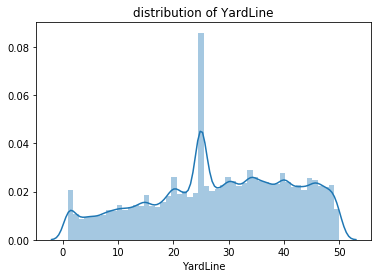

In [172]:
sns.distplot(train_df['YardLine'])
plt.title("distribution of "+ 'YardLine')
plt.show()

In [173]:
train_df['NflId']

0          496723
1         2495116
2         2495493
3         2506353
4         2530794
           ...   
509757    2555289
509758    2555395
509759    2556524
509760    2557891
509761    2558865
Name: NflId, Length: 509762, dtype: int32

In [174]:
new_yardline = train_df[train_df['NflId'] == train_df['NflIdRusher']]

In [175]:
new_yardline

,GameId,PlayId,Team,X,Y,S,A,Dis,Orientation,Dir,...,Week,Stadium,Location,StadiumType,Turf,GameWeather,Temperature,Humidity,WindSpeed,WindDirection
18,2017090700,20170907000118,home,78.750000,30.531250,3.630859,3.349609,0.379883,162.00000,245.750,...,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8,SW
40,2017090700,20170907000139,home,71.062500,27.156250,3.060547,2.410156,0.340088,210.75000,312.250,...,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8,SW
62,2017090700,20170907000189,home,48.656250,19.109375,5.769531,2.419922,0.600098,140.87500,222.000,...,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8,SW
84,2017090700,20170907000345,home,15.531250,25.359375,4.449219,3.199219,0.459961,186.25000,275.500,...,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8,SW
98,2017090700,20170907000395,away,29.984375,27.125000,3.900391,2.529297,0.439941,34.28125,157.875,...,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8,SW
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
509657,2018123015,20181230153910,away,49.562500,32.281250,3.990234,3.380859,0.389893,287.50000,290.250,...,17,CenturyLink Field,"Seattle, WA",Outdoor,FieldTurf,Cloudy,45.0,76.0,5,SE
509691,2018123015,20181230154035,home,31.000000,30.984375,4.179688,2.949219,0.399902,123.00000,151.000,...,17,CenturyLink Field,"Seattle, WA",Outdoor,FieldTurf,Cloudy,45.0,76.0,5,SE
509713,2018123015,20181230154082,home,39.937500,29.203125,4.671875,3.679688,0.449951,63.12500,41.250,...,17,CenturyLink Field,"Seattle, WA",Outdoor,FieldTurf,Cloudy,45.0,76.0,5,SE
509739,2018123015,20181230154135,home,81.187500,23.750000,4.230469,2.429688,0.409912,66.31250,41.250,...,17,CenturyLink Field,"Seattle, WA",Outdoor,FieldTurf,Cloudy,45.0,76.0,5,SE


In [176]:
new_yardline[['NflId','NflIdRusher','YardLine']]

,NflId,NflIdRusher,YardLine
18,2543773,2543773,35
40,2543773,2543773,43
62,2543773,2543773,35
84,2539663,2539663,2
98,2557917,2557917,25
...,...,...,...
509657,2553435,2553435,35
509691,2553439,2553439,25
509713,2553439,2553439,34
509739,2558865,2558865,25


In [177]:
new_yardline = train_df[train_df['NflId'] == train_df['NflIdRusher']]

In [178]:
new_yardline.reset_index(inplace=True)

In [179]:
new_yardline['new_yardline'] = 0.0

In [180]:
for i in range(len(new_yardline)):
    
    if new_yardline['PossessionTeam'][i] == new_yardline['FieldPosition'][i]:
        
        new_yardline['new_yardline'][i] = 10 + new_yardline['YardLine'][i]
        
    else :
        
        new_yardline['new_yardline'][i] = 60 + (50 - new_yardline['YardLine'][i])
        

In [181]:
new_yardline[['PossessionTeam','FieldPosition', 'YardLine', 'new_yardline']]

,PossessionTeam,FieldPosition,YardLine,new_yardline
0,NE,NE,35,45.0
1,NE,NE,43,53.0
2,NE,KC,35,75.0
3,NE,KC,2,108.0
4,KC,KC,25,35.0
...,...,...,...,...
23166,ARZ,SEA,35,75.0
23167,SEA,SEA,25,35.0
23168,SEA,SEA,34,44.0
23169,SEA,ARZ,25,85.0


In [182]:
train_df['new_x'] = 0.0

In [183]:
for i in range(len(train_df)):
    
    if train_df['PlayDirection'][i] == 'left':
        
        train_df['new_x'][i] = 120 - train_df['X'][i]
        
    else :
        
        train_df['new_x'][i] = train_df['X'][i]
        

In [184]:
train_df[['PlayDirection','X','new_x']]

,PlayDirection,X,new_x
0,left,73.9375,46.0625
1,left,74.6875,45.3125
2,left,74.0000,46.0000
3,left,71.4375,48.5625
4,left,69.3125,50.6875
...,...,...,...
509757,right,86.7500,86.7500
509758,right,86.7500,86.7500
509759,right,87.2500,87.2500
509760,right,84.5625,84.5625


In [185]:
df = pd.merge(train_df, new_yardline[['GameId','PlayId','new_yardline']], on=['GameId','PlayId'], how='inner')

In [186]:
df.columns

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'Yards', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection', 'new_x',
       'new_yardline'],
      dtype='object')

In [187]:
carriers = df[df['NflId'] == df['NflIdRusher']][['GameId',
                                                 'PlayId',
                                                 'NflIdRusher',
                                                 'X',
                                                 'Y',
                                                 'Orientation',
                                                 'Dir','new_yardline']]

In [188]:
carriers.head()

,GameId,PlayId,NflIdRusher,X,Y,Orientation,Dir,new_yardline
18,2017090700,20170907000118,2543773,78.750000,30.531250,162.00000,245.750,45.0
40,2017090700,20170907000139,2543773,71.062500,27.156250,210.75000,312.250,53.0
62,2017090700,20170907000189,2543773,48.656250,19.109375,140.87500,222.000,75.0
84,2017090700,20170907000345,2539663,15.531250,25.359375,186.25000,275.500,108.0
98,2017090700,20170907000395,2557917,29.984375,27.125000,34.28125,157.875,35.0


In [189]:
carriers['back_from_scrimmage'] = carriers['new_yardline'] - carriers['X']

In [190]:
carriers['back_oriented_down_field'] = 0.0

In [191]:
carriers.reset_index(inplace=True)

In [192]:
for i in range(len(carriers)):
    
    if carriers['Orientation'][i] > 180.0 :
        
        carriers['back_oriented_down_field'][i] = 1
        
    else :
        
        carriers['back_oriented_down_field'][i] = 0
        

In [193]:
carriers['back_moving_down_field'] = 0.0

In [194]:
for i in range(len(carriers)):
    
    if carriers['Dir'][i] > 180.0 :
        
        carriers['back_moving_down_field'][i] = 1
        
    else :
        
        carriers['back_moving_down_field'][i] = 0
        

In [195]:
carriers = carriers.rename(columns={'X':'back_X','Y':'back_Y'})
carriers = carriers[['GameId',
                     'PlayId',
                     'NflIdRusher',
                     'back_X',
                     'back_Y',
                     'back_from_scrimmage',
                     'back_oriented_down_field',
                     'back_moving_down_field']]

In [196]:
carriers.head()

,GameId,PlayId,NflIdRusher,back_X,back_Y,back_from_scrimmage,back_oriented_down_field,back_moving_down_field
0,2017090700,20170907000118,2543773,78.750000,30.531250,-33.750000,0.0,1.0
1,2017090700,20170907000139,2543773,71.062500,27.156250,-18.062500,1.0,1.0
2,2017090700,20170907000189,2543773,48.656250,19.109375,26.343750,0.0,1.0
3,2017090700,20170907000345,2539663,15.531250,25.359375,92.468750,1.0,1.0
4,2017090700,20170907000395,2557917,29.984375,27.125000,5.015625,0.0,0.0


In [197]:
back_feats = carriers.copy()

In [198]:
player_distance = df[['GameId','PlayId','NflId','X','Y']]

In [199]:
player_distance = pd.merge(player_distance, carriers, on=['GameId','PlayId'], how='inner')

In [200]:
player_distance = player_distance[player_distance['NflId'] != player_distance['NflIdRusher']]

In [201]:
player_distance.reset_index(inplace = True)

In [202]:
player_distance['dist_to_back'] = 0.0

In [203]:
for i in range(len(player_distance)):
        
    x_diff = (player_distance['X'][i] - player_distance['back_X'][i]) **2
    y_diff = (player_distance['Y'][i] - player_distance['back_Y'][i]) **2
        
    player_distance['dist_to_back'][i] = np.sqrt(x_diff + y_diff)

In [204]:
player_distance

,index,GameId,PlayId,NflId,X,Y,NflIdRusher,back_X,back_Y,back_from_scrimmage,back_oriented_down_field,back_moving_down_field,dist_to_back
0,0,2017090700,20170907000118,496723,73.9375,34.843750,2543773,78.7500,30.53125,-33.7500,0.0,1.0,6.462029
1,1,2017090700,20170907000118,2495116,74.6875,32.625000,2543773,78.7500,30.53125,-33.7500,0.0,1.0,4.570306
2,2,2017090700,20170907000118,2495493,74.0000,33.187500,2543773,78.7500,30.53125,-33.7500,0.0,1.0,5.442257
3,3,2017090700,20170907000118,2506353,71.4375,27.703125,2543773,78.7500,30.53125,-33.7500,0.0,1.0,7.840341
4,4,2017090700,20170907000118,2530794,69.3125,35.406250,2543773,78.7500,30.53125,-33.7500,0.0,1.0,10.622242
...,...,...,...,...,...,...,...,...,...,...,...,...,...
486586,509756,2018123015,20181230154157,2555185,85.6875,24.312500,2558865,80.8125,26.34375,6.1875,0.0,0.0,5.281250
486587,509757,2018123015,20181230154157,2555289,86.7500,24.203125,2558865,80.8125,26.34375,6.1875,0.0,0.0,6.311591
486588,509758,2018123015,20181230154157,2555395,86.7500,27.187500,2558865,80.8125,26.34375,6.1875,0.0,0.0,5.997151
486589,509759,2018123015,20181230154157,2556524,87.2500,27.046875,2558865,80.8125,26.34375,6.1875,0.0,0.0,6.475785


In [205]:
player_distance = player_distance.groupby(['GameId',
                                           'PlayId',
                                           'back_from_scrimmage',
                                           'back_oriented_down_field',
                                           'back_moving_down_field']).agg({'dist_to_back':['min',
                                                                                           'max',
                                                                                           'mean',
                                                                                           'std']}).reset_index()

In [206]:
player_distance

GameId          PlayId back_from_scrimmage  \
                                                        
0      2017090700  20170907000118          -33.750000   
1      2017090700  20170907000139          -18.062500   
2      2017090700  20170907000189           26.343750   
3      2017090700  20170907000345           92.468750   
4      2017090700  20170907000395            5.015625   
...           ...             ...                 ...   
23166  2018123015  20181230153910           25.437500   
23167  2018123015  20181230154035            4.000000   
23168  2018123015  20181230154082            4.062500   
23169  2018123015  20181230154135            3.812500   
23170  2018123015  20181230154157            6.187500   

      back_oriented_down_field back_moving_down_field dist_to_back             \
                                                               min        max   
0                          0.0                    1.0     1.447739  22.419997   
1                          1.0                    1.0     0.818637  23.006135   
2                          0.0                    1.0     1.639955  20.727598   
3                          1.0                    1.0     0.914430   9.797551   
4                          0.0                    0.0     0.489389  21.219291   
...                        ...                    ...          ...        ...   
23166                      1.0                    1.0     0.589002  19.334490   
23167                      0.0                    0.0     1.144471  25.495442   
23168                      0.0                    0.0     0.788250  19.444834   
23169                      0.0                    0.0     0.576222  19.102724   
23170                      0.0                    0.0     1.187603  18.915932   

                           
           mean       std  
0      8.047111  4.874150  
1      8.609753  5.594140  
2      8.478406  4.642201  
3      5.551141  1.984650  
4      9.173172  5.612118  
...         ...       ...  
23166  6.730878  4.513162  
23167  9.827399  7.472426  
23168  8.267865  5.545741  
23169  8.198244  5.832311  
23170  7.816898  4.536691  

[23171 rows x 9 columns]

In [207]:
player_distance.columns = ['GameId',
                           'PlayId',
                           'back_from_scrimmage',
                           'back_oriented_down_field',
                           'back_moving_down_field',
                           'min_dist','max_dist','mean_dist','std_dist']

In [208]:
player_distance.head()

,GameId,PlayId,back_from_scrimmage,back_oriented_down_field,back_moving_down_field,min_dist,max_dist,mean_dist,std_dist
0,2017090700,20170907000118,-33.750000,0.0,1.0,1.447739,22.419997,8.047111,4.874150
1,2017090700,20170907000139,-18.062500,1.0,1.0,0.818637,23.006135,8.609753,5.594140
2,2017090700,20170907000189,26.343750,0.0,1.0,1.639955,20.727598,8.478406,4.642201
3,2017090700,20170907000345,92.468750,1.0,1.0,0.914430,9.797551,5.551141,1.984650
4,2017090700,20170907000395,5.015625,0.0,0.0,0.489389,21.219291,9.173172,5.612118


In [209]:
rel_back = player_distance.copy()

In [210]:
rusher = df[df['NflId'] == df['NflIdRusher']][['GameId',
                                               'PlayId',
                                               'Team',
                                               'X',
                                               'Y']]

In [211]:
rusher.head()

,GameId,PlayId,Team,X,Y
18,2017090700,20170907000118,home,78.750000,30.531250
40,2017090700,20170907000139,home,71.062500,27.156250
62,2017090700,20170907000189,home,48.656250,19.109375
84,2017090700,20170907000345,home,15.531250,25.359375
98,2017090700,20170907000395,away,29.984375,27.125000


In [212]:
rusher.columns = ['GameId','PlayId','RusherTeam','RusherX','RusherY']

In [213]:
defense = pd.merge(df,rusher,on=['GameId','PlayId'],how='inner')

In [214]:
defense.head()

,GameId,PlayId,Team,X,Y,S,A,Dis,Orientation,Dir,...,GameWeather,Temperature,Humidity,WindSpeed,WindDirection,new_x,new_yardline,RusherTeam,RusherX,RusherY
0,2017090700,20170907000118,away,73.9375,34.843750,1.690430,1.129883,0.399902,82.000000,177.125,...,Clear and warm,63.0,77.0,8,SW,46.0625,45.0,home,78.75,30.53125
1,2017090700,20170907000118,away,74.6875,32.625000,0.419922,1.349609,0.010002,27.609375,198.750,...,Clear and warm,63.0,77.0,8,SW,45.3125,45.0,home,78.75,30.53125
2,2017090700,20170907000118,away,74.0000,33.187500,1.219727,0.589844,0.310059,3.009766,202.750,...,Clear and warm,63.0,77.0,8,SW,46.0000,45.0,home,78.75,30.53125
3,2017090700,20170907000118,away,71.4375,27.703125,0.419922,0.540039,0.020004,359.750000,105.625,...,Clear and warm,63.0,77.0,8,SW,48.5625,45.0,home,78.75,30.53125
4,2017090700,20170907000118,away,69.3125,35.406250,1.820312,2.429688,0.160034,12.632812,164.250,...,Clear and warm,63.0,77.0,8,SW,50.6875,45.0,home,78.75,30.53125


In [215]:
defense = defense[defense['Team'] != defense['RusherTeam']][['GameId',
                                                             'PlayId',
                                                             'X',
                                                             'Y',
                                                             'RusherX',
                                                             'RusherY']]

In [216]:
defense.reset_index(inplace=True)

In [217]:
defense['def_dist_to_back'] = 0.0

In [218]:
for i in range(len(defense)):
        
    x_diff = (defense['X'][i] - defense['RusherX'][i]) **2
    y_diff = (defense['Y'][i] - defense['RusherY'][i]) **2
        
    defense['def_dist_to_back'][i] = np.sqrt(x_diff + y_diff)

In [219]:
defense.head()

,index,GameId,PlayId,X,Y,RusherX,RusherY,def_dist_to_back
0,0,2017090700,20170907000118,73.9375,34.843750,78.75,30.53125,6.462029
1,1,2017090700,20170907000118,74.6875,32.625000,78.75,30.53125,4.570306
2,2,2017090700,20170907000118,74.0000,33.187500,78.75,30.53125,5.442257
3,3,2017090700,20170907000118,71.4375,27.703125,78.75,30.53125,7.840341
4,4,2017090700,20170907000118,69.3125,35.406250,78.75,30.53125,10.622242


In [220]:
defense = defense.groupby(['GameId',
                           'PlayId']).agg({'def_dist_to_back':['min',
                                                               'max',
                                                               'mean',
                                                               'std']}).reset_index()

defense.columns = ['GameId',
                   'PlayId',
                   'def_min_dist',
                   'def_max_dist',
                   'def_mean_dist',
                   'def_std_dist']

In [221]:
defense.head()

,GameId,PlayId,def_min_dist,def_max_dist,def_mean_dist,def_std_dist
0,2017090700,20170907000118,4.570306,22.419997,9.751146,5.328799
1,2017090700,20170907000139,4.267914,23.006135,10.286113,5.832733
2,2017090700,20170907000189,4.214726,20.727598,9.901085,5.071309
3,2017090700,20170907000345,4.531250,9.797551,6.311330,1.834362
4,2017090700,20170907000395,4.293038,21.219291,11.062788,5.898544


In [222]:
def_feats = defense.copy()

In [223]:
add_new_feas = []

In [224]:
# Height
df['PlayerHeight_dense'] = df['PlayerHeight'].apply(lambda x: 12*int(x.split('-')[0])+int(x.split('-')[1]))
add_new_feas.append('PlayerHeight_dense')

In [225]:
## Time
df['TimeHandoff'] = df['TimeHandoff'].apply(lambda x: datetime.datetime.strptime(x, "%Y-%m-%dT%H:%M:%S.%fZ"))
df['TimeSnap'] = df['TimeSnap'].apply(lambda x: datetime.datetime.strptime(x, "%Y-%m-%dT%H:%M:%S.%fZ"))
df['TimeDelta'] = df.apply(lambda row: (row['TimeHandoff'] - row['TimeSnap']).total_seconds(), axis=1)
df['PlayerBirthDate'] =df['PlayerBirthDate'].apply(lambda x: datetime.datetime.strptime(x, "%m/%d/%Y"))

In [226]:
## Age
seconds_in_year = 60*60*24*365.25
df['PlayerAge'] = df.apply(lambda row: (row['TimeHandoff']-row['PlayerBirthDate']).total_seconds()/seconds_in_year, axis=1)
add_new_feas.append('PlayerAge')

In [227]:
def strtofloat(x):
    try:
        return float(x)
    except:
        return -1

In [228]:
## WindSpeed
df['WindSpeed_ob'] = df['WindSpeed'].apply(lambda x: x.lower().replace('mph', '').strip() if not pd.isna(x) else x)
df['WindSpeed_ob'] = df['WindSpeed_ob'].apply(lambda x: (int(x.split('-')[0])+int(x.split('-')[1]))/2 if not pd.isna(x) and '-' in x else x)
df['WindSpeed_ob'] = df['WindSpeed_ob'].apply(lambda x: (int(x.split()[0])+int(x.split()[-1]))/2 if not pd.isna(x) and type(x)!=float and 'gusts up to' in x else x)
df['WindSpeed_dense'] = df['WindSpeed_ob'].apply(strtofloat)
add_new_feas.append('WindSpeed_dense')

In [229]:
def map_weather(txt):
    ans = 1
    if pd.isna(txt):
        return 0
    if 'partly' in txt:
        ans*=0.5
    if 'climate controlled' in txt or 'indoor' in txt:
        return ans*3
    if 'sunny' in txt or 'sun' in txt:
        return ans*2
    if 'clear' in txt:
        return ans
    if 'cloudy' in txt:
        return -ans
    if 'rain' in txt or 'rainy' in txt:
        return -2*ans
    if 'snow' in txt:
        return -3*ans
    return 0

In [230]:
df['GameWeather_process'] = df['GameWeather'].str.lower()
df['GameWeather_process'] = df['GameWeather_process'].apply(lambda x: "indoor" if not pd.isna(x) and "indoor" in x else x)
df['GameWeather_process'] = df['GameWeather_process'].apply(lambda x: x.replace('coudy', 'cloudy').replace('clouidy', 'cloudy').replace('party', 'partly') if not pd.isna(x) else x)
df['GameWeather_process'] = df['GameWeather_process'].apply(lambda x: x.replace('clear and sunny', 'sunny and clear') if not pd.isna(x) else x)
df['GameWeather_process'] = df['GameWeather_process'].apply(lambda x: x.replace('skies', '').replace("mostly", "").strip() if not pd.isna(x) else x)
df['GameWeather_dense'] = df['GameWeather_process'].apply(map_weather)
add_new_feas.append('GameWeather_dense')

In [231]:
def orientation_to_cat(x):
    x = np.clip(x, 0, 360 - 1)
    try:
        return str(int(x/15))
    except:
        return "nan"

In [232]:
## Orientation and Dir
df["Orientation_ob"] = df["Orientation"].apply(lambda x : orientation_to_cat(x)).astype("object")
df["Dir_ob"] = df["Dir"].apply(lambda x : orientation_to_cat(x)).astype("object")

df["Orientation_sin"] = df["Orientation"].apply(lambda x : np.sin(x/360 * 2 * np.pi))
df["Orientation_cos"] = df["Orientation"].apply(lambda x : np.cos(x/360 * 2 * np.pi))
df["Dir_sin"] = df["Dir"].apply(lambda x : np.sin(x/360 * 2 * np.pi))
df["Dir_cos"] = df["Dir"].apply(lambda x : np.cos(x/360 * 2 * np.pi))
add_new_feas.append("Dir_sin")
add_new_feas.append("Dir_cos")

In [233]:
## diff Score
df["diffScoreBeforePlay"] = df["HomeScoreBeforePlay"] - df["VisitorScoreBeforePlay"]
add_new_feas.append("diffScoreBeforePlay")



static_features = df[df['NflId'] == df['NflIdRusher']][add_new_feas+['GameId',
                                                                     'PlayId',
                                                                     'X','Y','S','A',
                                                                     'Dis',
                                                                     'Orientation',
                                                                     'Dir',
                                                                     'YardLine',
                                                                     'Quarter',
                                                                     'Down',
                                                                     'Distance',
                                                                     'DefendersInTheBox']].drop_duplicates()

static_features.fillna(-999,inplace=True)

In [234]:
static_features

,PlayerHeight_dense,PlayerAge,WindSpeed_dense,GameWeather_dense,Dir_sin,Dir_cos,diffScoreBeforePlay,GameId,PlayId,X,...,S,A,Dis,Orientation,Dir,YardLine,Quarter,Down,Distance,DefendersInTheBox
18,70,25.596251,8.0,1.0,-0.911762,-0.410719,0,2017090700,20170907000118,78.750000,...,3.630859,3.349609,0.379883,162.00000,245.750,35,1,3,2,6.0
40,70,25.596252,8.0,1.0,-0.740218,0.672367,0,2017090700,20170907000139,71.062500,...,3.060547,2.410156,0.340088,210.75000,312.250,43,1,1,10,6.0
62,70,25.596253,8.0,1.0,-0.669131,-0.743145,0,2017090700,20170907000189,48.656250,...,5.769531,2.419922,0.600098,140.87500,222.000,35,1,1,10,7.0
84,71,26.852933,8.0,1.0,-0.995396,0.095846,0,2017090700,20170907000345,15.531250,...,4.449219,3.199219,0.459961,186.25000,275.500,2,1,2,2,9.0
98,71,22.091819,8.0,1.0,0.376629,-0.926364,7,2017090700,20170907000395,29.984375,...,3.900391,2.529297,0.439941,34.28125,157.875,25,1,1,10,7.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
509657,73,27.041779,5.0,-1.0,-0.938191,0.346117,3,2018123015,20181230153910,49.562500,...,3.990234,3.380859,0.389893,287.50000,290.250,35,4,1,10,8.0
509691,69,25.861781,5.0,-1.0,0.484810,-0.874620,0,2018123015,20181230154035,31.000000,...,4.179688,2.949219,0.399902,123.00000,151.000,25,4,1,10,6.0
509713,69,25.861783,5.0,-1.0,0.659346,0.751840,0,2018123015,20181230154082,39.937500,...,4.671875,3.679688,0.449951,63.12500,41.250,34,4,3,1,7.0
509739,71,24.290258,5.0,-1.0,0.659346,0.751840,0,2018123015,20181230154135,81.187500,...,4.230469,2.429688,0.409912,66.31250,41.250,25,4,1,10,7.0


In [235]:
static_feats = static_features.copy()

In [236]:
df_eda = pd.merge(rel_back,def_feats,on=['GameId','PlayId'],how='inner')

In [237]:
df_eda.head()

,GameId,PlayId,back_from_scrimmage,back_oriented_down_field,back_moving_down_field,min_dist,max_dist,mean_dist,std_dist,def_min_dist,def_max_dist,def_mean_dist,def_std_dist
0,2017090700,20170907000118,-33.750000,0.0,1.0,1.447739,22.419997,8.047111,4.874150,4.570306,22.419997,9.751146,5.328799
1,2017090700,20170907000139,-18.062500,1.0,1.0,0.818637,23.006135,8.609753,5.594140,4.267914,23.006135,10.286113,5.832733
2,2017090700,20170907000189,26.343750,0.0,1.0,1.639955,20.727598,8.478406,4.642201,4.214726,20.727598,9.901085,5.071309
3,2017090700,20170907000345,92.468750,1.0,1.0,0.914430,9.797551,5.551141,1.984650,4.531250,9.797551,6.311330,1.834362
4,2017090700,20170907000395,5.015625,0.0,0.0,0.489389,21.219291,9.173172,5.612118,4.293038,21.219291,11.062788,5.898544


In [238]:
df_eda.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23171 entries, 0 to 23170
Data columns (total 13 columns):
GameId                      23171 non-null int64
PlayId                      23171 non-null int64
back_from_scrimmage         23171 non-null float64
back_oriented_down_field    23171 non-null float64
back_moving_down_field      23171 non-null float64
min_dist                    23171 non-null float64
max_dist                    23171 non-null float64
mean_dist                   23171 non-null float64
std_dist                    23171 non-null float64
def_min_dist                23171 non-null float64
def_max_dist                23171 non-null float64
def_mean_dist               23171 non-null float64
def_std_dist                23171 non-null float64
dtypes: float64(11), int64(2)
memory usage: 2.5 MB


In [239]:
df_eda = pd.merge(df_eda, static_feats, on=['GameId','PlayId'],how='inner')

In [240]:
df_eda

,GameId,PlayId,back_from_scrimmage,back_oriented_down_field,back_moving_down_field,min_dist,max_dist,mean_dist,std_dist,def_min_dist,...,S,A,Dis,Orientation,Dir,YardLine,Quarter,Down,Distance,DefendersInTheBox
0,2017090700,20170907000118,-33.750000,0.0,1.0,1.447739,22.419997,8.047111,4.874150,4.570306,...,3.630859,3.349609,0.379883,162.00000,245.750,35,1,3,2,6.0
1,2017090700,20170907000139,-18.062500,1.0,1.0,0.818637,23.006135,8.609753,5.594140,4.267914,...,3.060547,2.410156,0.340088,210.75000,312.250,43,1,1,10,6.0
2,2017090700,20170907000189,26.343750,0.0,1.0,1.639955,20.727598,8.478406,4.642201,4.214726,...,5.769531,2.419922,0.600098,140.87500,222.000,35,1,1,10,7.0
3,2017090700,20170907000345,92.468750,1.0,1.0,0.914430,9.797551,5.551141,1.984650,4.531250,...,4.449219,3.199219,0.459961,186.25000,275.500,2,1,2,2,9.0
4,2017090700,20170907000395,5.015625,0.0,0.0,0.489389,21.219291,9.173172,5.612118,4.293038,...,3.900391,2.529297,0.439941,34.28125,157.875,25,1,1,10,7.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23166,2018123015,20181230153910,25.437500,1.0,1.0,0.589002,19.334490,6.730878,4.513162,2.931676,...,3.990234,3.380859,0.389893,287.50000,290.250,35,4,1,10,8.0
23167,2018123015,20181230154035,4.000000,0.0,0.0,1.144471,25.495442,9.827399,7.472426,2.816360,...,4.179688,2.949219,0.399902,123.00000,151.000,25,4,1,10,6.0
23168,2018123015,20181230154082,4.062500,0.0,0.0,0.788250,19.444834,8.267865,5.545741,3.577954,...,4.671875,3.679688,0.449951,63.12500,41.250,34,4,3,1,7.0
23169,2018123015,20181230154135,3.812500,0.0,0.0,0.576222,19.102724,8.198244,5.832311,4.112196,...,4.230469,2.429688,0.409912,66.31250,41.250,25,4,1,10,7.0


In [249]:
df_eda = pd.merge(df_eda, df[['GameId','PlayId','Yards']], on=['GameId','PlayId'], how='inner')

In [250]:
df_eda.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 509762 entries, 0 to 509761
Data columns (total 33 columns):
GameId                      509762 non-null int64
PlayId                      509762 non-null int64
back_from_scrimmage         509762 non-null float64
back_oriented_down_field    509762 non-null float64
back_moving_down_field      509762 non-null float64
min_dist                    509762 non-null float64
max_dist                    509762 non-null float64
mean_dist                   509762 non-null float64
std_dist                    509762 non-null float64
def_min_dist                509762 non-null float64
def_max_dist                509762 non-null float64
def_mean_dist               509762 non-null float64
def_std_dist                509762 non-null float64
PlayerHeight_dense          509762 non-null int64
PlayerAge                   509762 non-null float64
WindSpeed_dense             509762 non-null float64
GameWeather_dense           509762 non-null float64
Dir_sin    

In [251]:
df_eda

,GameId,PlayId,back_from_scrimmage,back_oriented_down_field,back_moving_down_field,min_dist,max_dist,mean_dist,std_dist,def_min_dist,...,A,Dis,Orientation,Dir,YardLine,Quarter,Down,Distance,DefendersInTheBox,Yards
0,2017090700,20170907000118,-33.7500,0.0,1.0,1.447739,22.419997,8.047111,4.874150,4.570306,...,3.349609,0.379883,162.0,245.75,35,1,3,2,6.0,8
1,2017090700,20170907000118,-33.7500,0.0,1.0,1.447739,22.419997,8.047111,4.874150,4.570306,...,3.349609,0.379883,162.0,245.75,35,1,3,2,6.0,8
2,2017090700,20170907000118,-33.7500,0.0,1.0,1.447739,22.419997,8.047111,4.874150,4.570306,...,3.349609,0.379883,162.0,245.75,35,1,3,2,6.0,8
3,2017090700,20170907000118,-33.7500,0.0,1.0,1.447739,22.419997,8.047111,4.874150,4.570306,...,3.349609,0.379883,162.0,245.75,35,1,3,2,6.0,8
4,2017090700,20170907000118,-33.7500,0.0,1.0,1.447739,22.419997,8.047111,4.874150,4.570306,...,3.349609,0.379883,162.0,245.75,35,1,3,2,6.0,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
509757,2018123015,20181230154157,6.1875,0.0,0.0,1.187603,18.915932,7.816898,4.536691,5.326544,...,4.101562,0.449951,135.5,118.25,23,4,2,8,9.0,11
509758,2018123015,20181230154157,6.1875,0.0,0.0,1.187603,18.915932,7.816898,4.536691,5.326544,...,4.101562,0.449951,135.5,118.25,23,4,2,8,9.0,11
509759,2018123015,20181230154157,6.1875,0.0,0.0,1.187603,18.915932,7.816898,4.536691,5.326544,...,4.101562,0.449951,135.5,118.25,23,4,2,8,9.0,11
509760,2018123015,20181230154157,6.1875,0.0,0.0,1.187603,18.915932,7.816898,4.536691,5.326544,...,4.101562,0.449951,135.5,118.25,23,4,2,8,9.0,11


In [252]:
df_eda.to_csv("nfl_eda_1.csv")